In [1]:
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
if not os.path.isdir(r'/kaggle/working/valid'):
    os.makedirs(r'/kaggle/working/valid')
    for label in os.listdir(r'/kaggle/input/handsignimages/Test'):
        images=random.sample(os.listdir(r'/kaggle/input/handsignimages/Test/'+label),int(len(os.listdir('/kaggle/input/handsignimages/Test/'+label))/2))
        for image in images:
            if not os.path.isdir(f'/kaggle/working/valid/{label}'):
                os.makedirs(f'/kaggle/working/valid/{label}')
            shutil.copy(f'/kaggle/input/handsignimages/Test/{label}/{image}',f'/kaggle/working/valid/{label}')

In [3]:
train_batche=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory='/kaggle/input/handsignimages/Test',batch_size=124,target_size=(224,224))
valid_batche=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory='/kaggle/input/handsignimages/Train',batch_size=124,target_size=(224,224))
test_batche=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory='/kaggle/working/valid',batch_size=124,shuffle=False,target_size=(224,224))

Found 7172 images belonging to 24 classes.
Found 27455 images belonging to 24 classes.
Found 3582 images belonging to 24 classes.


In [4]:
mobile=mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [5]:
x=mobile.layers[-6].output
x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(.5)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(.5)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(.6)(x)
output=Dense(24,activation='softmax')(x)

In [6]:
model=Model(inputs=mobile.input,outputs=output)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [8]:
for layer in model.layers[:-17]:
    layer.trainable=False

In [9]:
model.compile(optimizer=Adam(0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
epochs=30
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')


batch_size=124
model.fit(x=train_batche,batch_size=batch_size,validation_data=valid_batche,epochs=epochs,verbose=2,callbacks=[checkpoint,early_stop])

Epoch 1/30

Epoch 1: val_loss improved from inf to 2.58329, saving model to best_model.h5
58/58 - 290s - loss: 3.7433 - accuracy: 0.1481 - val_loss: 2.5833 - val_accuracy: 0.4964 - 290s/epoch - 5s/step
Epoch 2/30

Epoch 2: val_loss improved from 2.58329 to 1.68408, saving model to best_model.h5
58/58 - 116s - loss: 2.1806 - accuracy: 0.3695 - val_loss: 1.6841 - val_accuracy: 0.6868 - 116s/epoch - 2s/step
Epoch 3/30

Epoch 3: val_loss improved from 1.68408 to 1.10960, saving model to best_model.h5
58/58 - 114s - loss: 1.5005 - accuracy: 0.5519 - val_loss: 1.1096 - val_accuracy: 0.7740 - 114s/epoch - 2s/step
Epoch 4/30

Epoch 4: val_loss improved from 1.10960 to 0.74988, saving model to best_model.h5
58/58 - 116s - loss: 0.9383 - accuracy: 0.7188 - val_loss: 0.7499 - val_accuracy: 0.8365 - 116s/epoch - 2s/step
Epoch 5/30

Epoch 5: val_loss improved from 0.74988 to 0.59839, saving model to best_model.h5
58/58 - 115s - loss: 0.6313 - accuracy: 0.8061 - val_loss: 0.5984 - val_accuracy: 0.85

In [11]:

# Define the path to the model weights file
weights_path = '/kaggle/working/best_model.h5'



# Load the weights into the model
model.load_weights(weights_path)

In [12]:
test_labels = test_batche.classes
test_labels

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [13]:
predictions = model.predict(x=test_batche, steps=len(test_batche), verbose=0)

In [14]:
prediction=np.argmax(predictions,axis=-1)

In [15]:
accuracy=sum(prediction==test_labels)/len(prediction)
accuracy

1.0

In [16]:
confusion_matrix = confusion_matrix(test_labels,predictions.argmax(axis=1))
confusion_matrix
print(classification_report(test_labels, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       216
           2       1.00      1.00      1.00       155
           3       1.00      1.00      1.00       122
           4       1.00      1.00      1.00       249
           5       1.00      1.00      1.00       123
           6       1.00      1.00      1.00       174
           7       1.00      1.00      1.00       218
           8       1.00      1.00      1.00       144
           9       1.00      1.00      1.00       165
          10       1.00      1.00      1.00       104
          11       1.00      1.00      1.00       197
          12       1.00      1.00      1.00       145
          13       1.00      1.00      1.00       123
          14       1.00      1.00      1.00       173
          15       1.00      1.00      1.00        82
          16       1.00      1.00      1.00        72
          17       1.00    

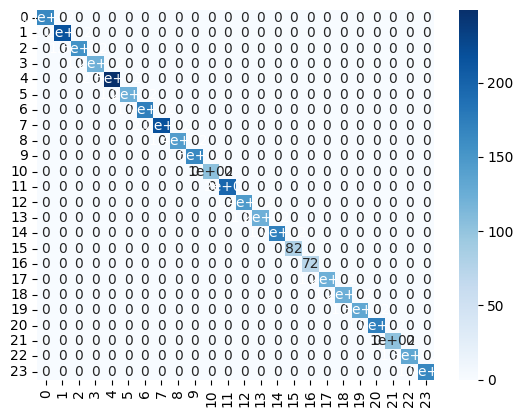

In [17]:
sn.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues)
plt.show()

In [18]:
def prdict_custom_image(path):
    image=cv2.imread(path)
    image=cv2.resize(image,(224,224))

    image=np.expand_dims(image,axis=0)
    image=mobilenet.preprocess_input(image)
    prediction_image=np.argmax(model.predict(image,verbose=0),axis=-1)
    return prediction_image

In [19]:
prdict_custom_image(r'/kaggle/input/handsignimages/Test/A/1003_A.jpg')

array([0])